<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_03_03_survival_analysis_log_normal_model_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 3.3 The Log-Normal Survival Model


This tutorial covers the Log-Normal survival model, including its theoretical background, implementation in Python, and practical examples using the `lifelines` package. We will also address common pitfalls and provide diagnostic tools to assess model fit.


## Overview


The Log-Normal survival model is a parametric model used in survival analysis where the logarithm of the survival time $T$, denoted $\ln(T)$, follows a normal distribution, i.e., $\ln(T) \sim \mathcal{N}(\mu, \sigma^2)$. Here, $\mu$ is the mean of the log-time (location parameter), and $\sigma > 0$ is the standard deviation (scale parameter). This model is part of the Accelerated Failure Time (AFT) framework, where covariates scale the survival time multiplicatively, accelerating or decelerating the time to an event (e.g., death, failure).


### Key Features


- **Hazard Function**: Unlike the exponential or Weibull models, the log-normal model has a non-monotonic hazard function that typically increases to a peak and then decreases, making it suitable for scenarios where the risk rises initially (e.g., post-surgery complications) and later declines (e.g., recovery phase). For small $\sigma$, the hazard may be monotonically decreasing.
- **Applications**: Commonly used in medical research (e.g., time to disease recurrence), reliability engineering (e.g., component failure times), or economics (e.g., duration of unemployment) when survival times are positively skewed and hazards are arc-shaped.
- **Assumptions**: Assumes $\ln(T)$ is normally distributed, implying $T$ is log-normally distributed. This is appropriate when empirical hazard plots (e.g., from Kaplan-Meier) suggest a non-monotonic or decreasing hazard.
- **Limitations**: Not suitable for monotonically increasing hazards (use Weibull instead). It does not naturally fit a proportional hazards framework like the Cox model, though it can be adapted.


- **Probability Density Function (PDF)**:

$$
  f(t) = \frac{1}{t \sigma \sqrt{2\pi}} \exp\left( -\frac{(\ln(t) - \mu)^2}{2\sigma^2} \right), \quad t > 0
$$
  This describes the distribution of survival times, skewed to the right due to the log transformation.
  
- **Survival Function**:

$$
  S(t) = 1 - \Phi\left( \frac{\ln(t) - \mu}{\sigma} \right)
$$

  where $\Phi$ is the standard normal cumulative distribution function (CDF). This gives the probability of surviving past time $t$.
  
- **Hazard Function**:

$$
  h(t) = \frac{f(t)}{S(t)} = \frac{\frac{1}{t \sigma \sqrt{2\pi}} \exp\left( -\frac{(\ln(t) - \mu)^2}{2\sigma^2} \right)}{1 - \Phi\left( \frac{\ln(t) - \mu}{\sigma} \right)}
$$
  No closed form exists, but it typically rises to a peak and then falls (arc-shaped) for \( \sigma > 1 \), or is decreasing for \( \sigma \leq 1 \).
  
- **Mean and Variance**:

  - Mean: $E[T] = e^{\mu + \sigma^2/2}$
  - Variance: $\text{Var}(T) = e^{2\mu + \sigma^2} (e^{\sigma^2} - 1)$


### When to Use


Choose the log-normal model when:

- Nonparametric hazard estimates (e.g., from Kaplan-Meier or kernel smoothing) show an arc-shaped or decreasing hazard.
- Survival times are positively skewed, and log-transformation normalizes them.
- You prefer an AFT model to interpret covariate effects as time scaling (e.g., a positive coefficient extends survival time).


### Model Fit Assessment


- Use AIC/BIC to compare with other models (e.g., Weibull, exponential).
- Check residuals (e.g., Cox-Snell) or compare fitted survival curves to Kaplan-Meier estimates.
- Validate the log-normal assumption with Q-Q plots of log-times or hazard shape diagnostics.


## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'lifelines']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing lifelines...
lifelines installed successfully
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✓ lifelines


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import LogNormalFitter, KaplanMeierFitter
from lifelines.plotting import plot_lifetimes
from lifelines.utils import survival_table_from_events, datetimes_to_durations

import warnings
warnings.filterwarnings("ignore")

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

## Implementation in Python

### Data Preparation

In [3]:
# Load the dataset
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/lung_dataset.csv"
lung_data = pd.read_csv(url)
# Create working copy
data = lung_data.copy()

# Preprocessing
# Original: sex: 1=male, 2=female → convert to 0=male, 1=female
data['sex'] = data['sex'].map({1: 0, 2: 1})
data['sex'] = data['sex'].astype('category')
data['sex_name'] = data['sex'].map({0: 'Male', 1: 'Female'})

# Handle missing values in ECOG performance score (ph.ecog)
data['ph.ecog'].fillna(data['ph.ecog'].median(), inplace=True)

# Event indicator: status == 1 → death (event), status == 2 → censored
data['event'] = (data['status'] == 1).astype(int)

# Select key variables
df = data[['time', 'event', 'age', 'sex', 'wt.loss', 'ph.ecog']].copy()

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nEvent rate:", df['event'].mean().round(3))

Dataset shape: (228, 6)

First 5 rows:
   time  event  age sex  wt.loss  ph.ecog
0   306      0   74   0      NaN      1.0
1   455      0   68   0     15.0      0.0
2  1010      1   56   0     15.0      0.0
3   210      0   57   0     11.0      1.0
4   883      0   60   0      0.0      0.0

Event rate: 0.276


### Model Fitting


- **Null Model**: `lnorm_model` fits a baseline log-normal model (`~ 1`).
- **Covariate Model**: `lnorm_model_cov` includes `age_centered` and `sex`. Coefficients represent shifts in $\mu$ (log-time); positive values extend survival time.
- **Output**: `summary(lnorm_model_cov)` shows $\mu$ (Intercept), coefficients, and $\sigma$ (Scale).


In [4]:
# Fit log-normal model (null model)
lnf = LogNormalFitter()
lnf.fit(df['time'], event_observed=df['event'])

print(lnf.summary)
lnf.print_summary()

            coef  se(coef)  coef lower 95%  coef upper 95%  cmp to          z  \
mu_     6.327251  0.077770        6.174824        6.479678     0.0  81.358189   
sigma_  0.692888  0.061125        0.573084        0.812691     1.0  -5.024310   

                   p  -log2(p)  
mu_     0.000000e+00       inf  
sigma_  5.052462e-07  20.91651  


<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 228 total observations, 165 right-censored observations>
   number of observations = 228
number of events observed = 63
           log-likelihood = -478.57
               hypothesis = mu_ != 0, sigma_ != 1

---
        coef  se(coef)  coef lower 95%  coef upper 95%
mu_     6.33      0.08            6.17            6.48
sigma_  0.69      0.06            0.57            0.81

        cmp to     z      p  -log2(p)
mu_       0.00 81.36 <0.005       inf
sigma_    1.00 -5.02 <0.005     20.92
---
AIC = 961.14

**Key Output Interpretation:**

- mu_: mean of log-time → intercept
- sigma_: scale parameter (larger → more spread, more peaked hazard)

### Kaplan-Meier vs Fitted Log-Normal Survival Curve

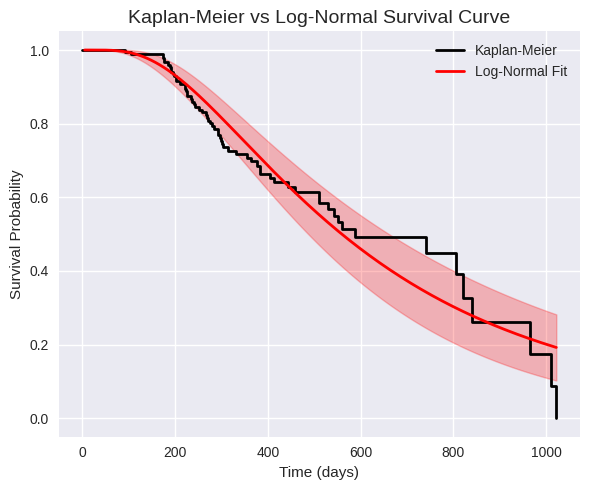

In [5]:
# Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(df['time'], event_observed=df['event'], label='Kaplan-Meier')

# Plot
fig, ax = plt.subplots(figsize=(6, 5))

kmf.plot_survival_function(ax=ax, ci_show=False, color='black', linewidth=2)

# Add fitted log-normal curve
lnf.plot_survival_function(ax=ax, color='red', linewidth=2, label='Log-Normal Fit')

ax.set_title('Kaplan-Meier vs Log-Normal Survival Curve', fontsize=14)
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival Probability')
ax.legend()
plt.tight_layout()
plt.show()

### Log-Normal AFT Model with Covariates

In [6]:
from lifelines import LogNormalAFTFitter

# Prepare data
aft_df = df.copy()
aft_df['sex'] = aft_df['sex'].astype(float)  # lifelines requires numeric

# Fit AFT log-normal model
aft_lognormal = LogNormalAFTFitter()
aft_lognormal.fit(aft_df, duration_col='time', event_col='event', formula="age + sex + ph.ecog")

aft_lognormal.print_summary(decimals=3)

<lifelines.LogNormalAFTFitter: fitted with 228 total observations, 165 right-censored observations>
             duration col = 'time'
                event col = 'event'
   number of observations = 228
number of events observed = 63
           log-likelihood = -475.807
         time fit was run = 2026-01-08 20:46:17 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                   
mu_    Intercept  6.059   428.079     0.458           5.161           6.958             174.293            1051.396
       age        0.006     1.006     0.007          -0.009           0.020               0.991               1.020
       sex       -0.257     0.773     0.134          -0.519           0.005               0.595               1.005
       ph.ecog    0.070     1.073     0.104          -0.133           0.273               0.876               1.314
sigma_ Intercept -0.364     0.695     0.089          -0.539          -0.189               0.583               0.828

                  cmp to      z       p  -log2(p)
param  covariate                                 
mu_    Intercept   0.000 13.217 <0.0005   130.063
       age         0.000  0.748   0.454     1.138
       sex         0.000 -1.923   0.054     4.198
       ph.ecog     0.000  0.677   0.499     1.004
sigma_ Intercept   0.000 -4.074 <0.0005    14.403
---
Concordance = 0.583
AIC = 961.614
log-likelihood ratio test = 5.530 on 3 df
-log2(p) of ll-ratio test = 2.870

**Interpretation of Coefficients (AFT scale)**

- Positive coefficient → increases log-time → prolongs survival (time acceleration factor > 1)
- Negative coefficient → shortens survival

### Predictions


- **Median Time**:  the median survival time for the log-normal model.
- **Survival Probability**: the probability of surviving beyond a specified time (e.g., 5 years) for given covariate values.


In [7]:
# Predict for a 65-year-old female, ECOG = 1
new_patient = pd.DataFrame({
    'age': [65],
    'sex': [1],      # 1 = female
    'ph.ecog': [1]
})

median_time = aft_lognormal.predict_median(new_patient)
print(f"Predicted median survival time: {median_time.values[0]:.1f} days")

Predicted median survival time: 511.1 days


### Survival & Hazard Function Plots for Specific Profiles

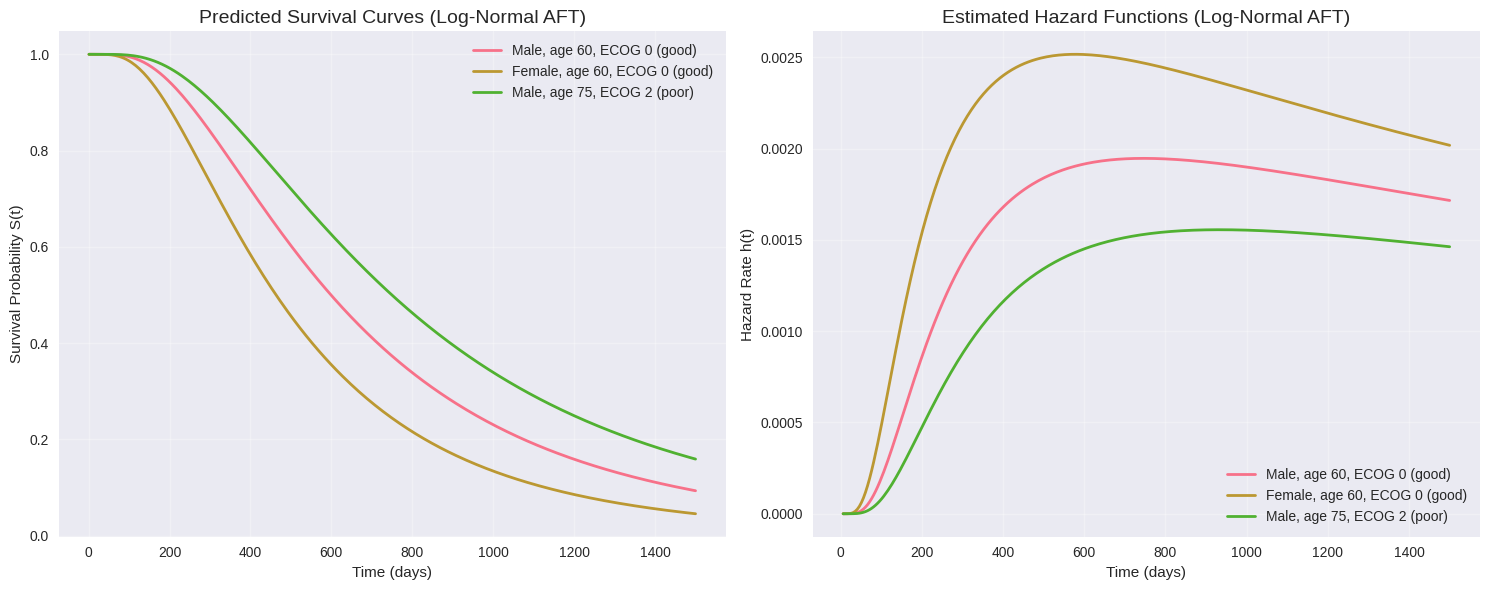

In [8]:
# Survival & Hazard Function Plots for Specific Profiles (FIXED VERSION)

times = np.linspace(1, 1500, 300)

# Define patient profiles
profiles = [
    {'age': 60, 'sex': 0, 'ph.ecog': 0, 'label': 'Male, age 60, ECOG 0 (good)'},
    {'age': 60, 'sex': 1, 'ph.ecog': 0, 'label': 'Female, age 60, ECOG 0 (good)'},
    {'age': 75, 'sex': 0, 'ph.ecog': 2, 'label': 'Male, age 75, ECOG 2 (poor)'}
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

for prof in profiles:
    # Create one-row DataFrame
    newdata = pd.DataFrame([prof])

    # Predict survival function → returns a Series indexed by times
    S = aft_lognormal.predict_survival_function(newdata, times=times).iloc[:, 0]  # take first (only) column

    # Ensure we have clean numpy arrays
    S = S.values.flatten()
    t = times.copy()

    # Survival curve
    ax1.plot(t, S, label=prof['label'], linewidth=2)

    # Numerical hazard: h(t) ≈ -d[ln S(t)] / dt
    logS = np.log(S + 1e-12)        # avoid log(0)
    hazard = -np.diff(logS) / np.diff(t)
    ax2.plot(t[1:], hazard, label=prof['label'], linewidth=2)

# Beautify
ax1.set_title('Predicted Survival Curves (Log-Normal AFT)', fontsize=14)
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Survival Probability S(t)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_title('Estimated Hazard Functions (Log-Normal AFT)', fontsize=14)
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Hazard Rate h(t)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Model Diagnostics

#### Q-Q Plot for Log-Normal Assumption

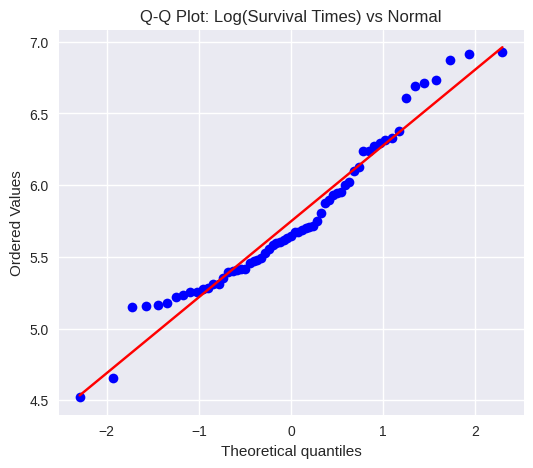

In [9]:
observed_log_times = np.log(df[df['event'] == 1]['time'])

fig, ax = plt.subplots(figsize=(6, 5))
from scipy import stats
stats.probplot(observed_log_times, dist="norm", plot=ax)
ax.set_title("Q-Q Plot: Log(Survival Times) vs Normal")
ax.get_lines()[1].set_color('red')
plt.show()

### Compare Models with AIC

In [10]:
# Compare Univariate Parametric Models with AIC

from lifelines import LogNormalFitter, WeibullFitter, ExponentialFitter

# Extract durations and events as numpy arrays
durations = df['time'].values
events = df['event'].values

# Dictionary of univariate parametric models
models = {
    'Log-Normal': LogNormalFitter(),
    'Weibull'   : WeibullFitter(),
    'Exponential': ExponentialFitter()
}

# Fit each model and collect AIC
results = []
for name, model in models.items():
    model.fit(durations=durations, event_observed=events)
    results.append({
        'Model': name,
        'AIC'  : model.AIC_,
        'Log-likelihood': model.log_likelihood_
    })

# Display results
comparison_df = pd.DataFrame(results).sort_values('AIC').reset_index(drop=True)
print("Univariate Parametric Model Comparison")
print(comparison_df.round(2))

# Optional: Visualize which model fits best
print("\n→ Lower AIC = better fit")
print(f"→ Best model: {comparison_df.loc[0, 'Model']} (AIC = {comparison_df.loc[0, 'AIC']:.2f})")

Univariate Parametric Model Comparison
         Model      AIC  Log-likelihood
0   Log-Normal   961.14         -478.57
1      Weibull   971.06         -483.53
2  Exponential  1010.92         -504.46

→ Lower AIC = better fit
→ Best model: Log-Normal (AIC = 961.14)


## Summary and Conclusion


The Log-Normal survival model is a powerful parametric approach for analyzing time-to-event data, particularly when the hazard function is non-monotonic. By assuming that the logarithm of survival times follows a normal distribution, this model provides a flexible framework for understanding how covariates influence survival times through an Accelerated Failure Time (AFT) perspective.



## Resources


1. lifelines Documentation: https://lifelines.readthedocs.io

2. Book: "Survival Analysis Using Python" – Davidson-Pilon

3. Scikit-survival: https://scikit-survival.readthedocs.io

4. Paper: AFT Models – Wei (1992), JRSS-B
